# Mass-Scale Dependence of Baryonic Effects on Weak Lensing Power Spectrum

**Key Question**: How low in mass and how far in radius must we correctly model halo profiles to capture P(k) suppression from baryonic feedback?

This notebook presents publication-ready figures from the Replace formalism analysis using IllustrisTNG L205n2500 (205 Mpc/h box, $2500^3$ particles).

---

## Summary of Key Results

| Finding | Value |
|---------|-------|
| Mass threshold for 68% | M > 10¹³ M☉/h |
| Contribution from 10¹²-10¹².⁵ | Only 6.5% |
| Per-halo efficiency ratio | 146× (massive vs low-mass) |
| Most volume-efficient bin | 10¹³-10¹³.⁵ |
| Total volume fraction at α=5 | 4.0% |

**Implication**: BCM efforts should prioritize M > 10¹³ halos at z < 1

In [6]:
# Setup and data loading
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
import h5py

# Publication style
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.linewidth': 1.0,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
})

OUTPUT_DIR = Path('publication_figures')
OUTPUT_DIR.mkdir(exist_ok=True)

# CORRECT path: density_statistics_cache (not statistics_cache)
STATS_DIR = Path('density_statistics_cache')

# Simulation parameters
BOX_SIZE = 205.0  # Mpc/h
V_BOX = BOX_SIZE**3

print(f"Stats directory: {STATS_DIR}")
print(f"Files found: {len(list(STATS_DIR.glob('*.h5')))}")

Stats directory: density_statistics_cache
Files found: 34


In [7]:
# ============================================================
# Load response data from density statistics cache
# ============================================================

# Snapshot to redshift mapping (20 snapshots)
SNAPSHOT_NUMS = [96, 90, 85, 80, 76, 71, 67, 63, 59, 56, 52, 49, 46, 43, 41, 38, 35, 33, 31, 29]
SNAPSHOT_Z = [0.02, 0.10, 0.18, 0.27, 0.35, 0.46, 0.55, 0.65, 0.76, 0.85,
              0.97, 1.08, 1.21, 1.36, 1.47, 1.63, 1.82, 1.97, 2.14, 2.32]
INDEX_TO_Z = {i: z for i, z in enumerate(SNAPSHOT_Z)}

# Mass thresholds and labels
MASS_THRESHOLDS = ['1.00e12', '3.16e12', '1.00e13', '3.16e13']
MASS_BINS = ['10¹²-10¹².⁵', '10¹².⁵-10¹³', '10¹³-10¹³.⁵', '10¹³.⁵+']
MASS_BINS_REV = ['10¹³.⁵+', '10¹³-10¹³.⁵', '10¹².⁵-10¹³', '10¹²-10¹².⁵']  # For stacking
ALPHA_VALUES = ['0.5', '1.0', '3.0', '5.0']

# Colors for mass bins (red gradient - darker = more massive)
COLORS_MASS = ['#cb181d', '#fb6a4a', '#fcae91', '#fee5d9']

def load_model_stats(model_name, snapshot_id=None):
    """Load statistics for a model, optionally filtering by snapshot."""
    fname = STATS_DIR / f'{model_name}_density_stats.h5'
    if not fname.exists():
        return None
    
    with h5py.File(fname, 'r') as f:
        k = f['k'][:]
        Pk = f['Pk'][:]
        snapshot_ids = f['snapshot_ids'][:]
        
        if snapshot_id is not None:
            # Filter to specific snapshot
            mask = snapshot_ids == snapshot_id
            if not np.any(mask):
                return None
            Pk = Pk[mask]
        
        return {
            'k': k,
            'Pk': Pk,
            'snapshot_ids': snapshot_ids if snapshot_id is None else snapshot_ids[mask],
        }

# Load DMO and Hydro baselines
dmo_stats = load_model_stats('dmo')
hydro_stats = load_model_stats('hydro')

print(f"DMO: {dmo_stats['Pk'].shape[0]} realizations, k range [{dmo_stats['k'].min():.3f}, {dmo_stats['k'].max():.1f}] h/Mpc")
print(f"Hydro: {hydro_stats['Pk'].shape[0]} realizations")
print(f"Unique snapshots: {np.unique(dmo_stats['snapshot_ids'])}")

DMO: 400 realizations, k range [0.037, 88.8] h/Mpc
Hydro: 400 realizations
Unique snapshots: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [8]:
# ============================================================
# Compute response fractions F(M_min, α) for all snapshots
# ============================================================

K_TARGET = 10.0  # h/Mpc - focus scale for analysis
BARYONIC_THRESHOLD = 0.01  # 1% threshold for significance

def compute_F_at_k(dmo_Pk, hydro_Pk, replace_Pk, k_arr, k_target):
    """Compute response fraction F at target wavenumber."""
    k_idx = np.argmin(np.abs(k_arr - k_target))
    
    P_d = np.mean(dmo_Pk[:, k_idx])
    P_h = np.mean(hydro_Pk[:, k_idx])
    P_r = np.mean(replace_Pk[:, k_idx])
    
    Delta_P = P_h - P_d
    if np.abs(Delta_P) < BARYONIC_THRESHOLD * np.abs(P_d):
        return np.nan  # Below significance threshold
    
    return (P_r - P_d) / Delta_P

# Get unique snapshots in the data
unique_snaps = np.unique(dmo_stats['snapshot_ids'])
print(f"Available snapshots: {unique_snaps}")

# Compute F for all (mass, alpha, snapshot) combinations
F_vs_z = {}
k_arr = dmo_stats['k']

for snap_id in unique_snaps:
    # Get DMO and Hydro for this snapshot
    dmo_snap = load_model_stats('dmo', snapshot_id=snap_id)
    hydro_snap = load_model_stats('hydro', snapshot_id=snap_id)
    
    if dmo_snap is None or hydro_snap is None:
        continue
    
    F_vs_z[snap_id] = {}
    
    for m in MASS_THRESHOLDS:
        for a in ALPHA_VALUES:
            model_name = f'hydro_replace_Ml_{m}_Mu_inf_R_{a}'
            replace_snap = load_model_stats(model_name, snapshot_id=snap_id)
            
            if replace_snap is not None and len(replace_snap['Pk']) > 0:
                F = compute_F_at_k(dmo_snap['Pk'], hydro_snap['Pk'], 
                                   replace_snap['Pk'], k_arr, K_TARGET)
                F_vs_z[snap_id][(m, a)] = F

print(f"\n✓ Computed F for {len(F_vs_z)} snapshots")
for snap_id in sorted(F_vs_z.keys()):
    z = INDEX_TO_Z.get(snap_id, 'N/A')
    n_configs = len(F_vs_z[snap_id])
    print(f"  Snapshot {snap_id} (z={z}): {n_configs} configurations")

Available snapshots: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

✓ Computed F for 20 snapshots
  Snapshot 0 (z=0.02): 16 configurations
  Snapshot 1 (z=0.1): 16 configurations
  Snapshot 2 (z=0.18): 16 configurations
  Snapshot 3 (z=0.27): 16 configurations
  Snapshot 4 (z=0.35): 16 configurations
  Snapshot 5 (z=0.46): 16 configurations
  Snapshot 6 (z=0.55): 16 configurations
  Snapshot 7 (z=0.65): 16 configurations
  Snapshot 8 (z=0.76): 16 configurations
  Snapshot 9 (z=0.85): 16 configurations
  Snapshot 10 (z=0.97): 16 configurations
  Snapshot 11 (z=1.08): 16 configurations
  Snapshot 12 (z=1.21): 16 configurations
  Snapshot 13 (z=1.36): 16 configurations
  Snapshot 14 (z=1.47): 16 configurations
  Snapshot 15 (z=1.63): 16 configurations
  Snapshot 16 (z=1.82): 16 configurations
  Snapshot 17 (z=1.97): 16 configurations
  Snapshot 18 (z=2.14): 16 configurations
  Snapshot 19 (z=2.32): 16 configurations


In [9]:
# ============================================================
# Pre-computed halo statistics from IllustrisTNG catalog
# ============================================================

# Halo counts per mass bin at different redshifts
HALO_COUNTS = {
    0: {'10¹²-10¹².⁵': 18718, '10¹².⁵-10¹³': 5450, '10¹³-10¹³.⁵': 1773, '10¹³.⁵+': 729},
    5: {'10¹²-10¹².⁵': 20525, '10¹².⁵-10¹³': 5640, '10¹³-10¹³.⁵': 1677, '10¹³.⁵+': 536},
    10: {'10¹²-10¹².⁵': 19716, '10¹².⁵-10¹³': 4942, '10¹³-10¹³.⁵': 1211, '10¹³.⁵+': 275},
    15: {'10¹²-10¹².⁵': 14967, '10¹².⁵-10¹³': 3242, '10¹³-10¹³.⁵': 571, '10¹³.⁵+': 62},
    19: {'10¹²-10¹².⁵': 8294, '10¹².⁵-10¹³': 1268, '10¹³-10¹³.⁵': 123, '10¹³.⁵+': 8},
}

# Overlap-corrected volumes at z=0, α=5.0 (Mpc/h)³
VOLUME_UNION = {
    '10¹³.⁵+': 1.3499e+05,
    '10¹³-10¹³.⁵': 7.0270e+04,
    '10¹².⁵-10¹³': 6.8140e+04,
    '10¹²-10¹².⁵': 7.2988e+04,
}

# Mean R_200 values (Mpc/h)
MEAN_R200 = {
    '10¹³.⁵+': 0.682,
    '10¹³-10¹³.⁵': 0.423,
    '10¹².⁵-10¹³': 0.287,
    '10¹²-10¹².⁵': 0.195,
}

---
## Figure 1: Mass Contribution Hierarchy

**Key Result**: At z=0, halos with M > 10¹³ M☉/h account for 68% of the P(k) suppression at k=10 h/Mpc. The lowest mass bin (10¹²-10¹².⁵) contributes only 6.5%.

Saved: publication_figures/fig1_mass_contribution.pdf


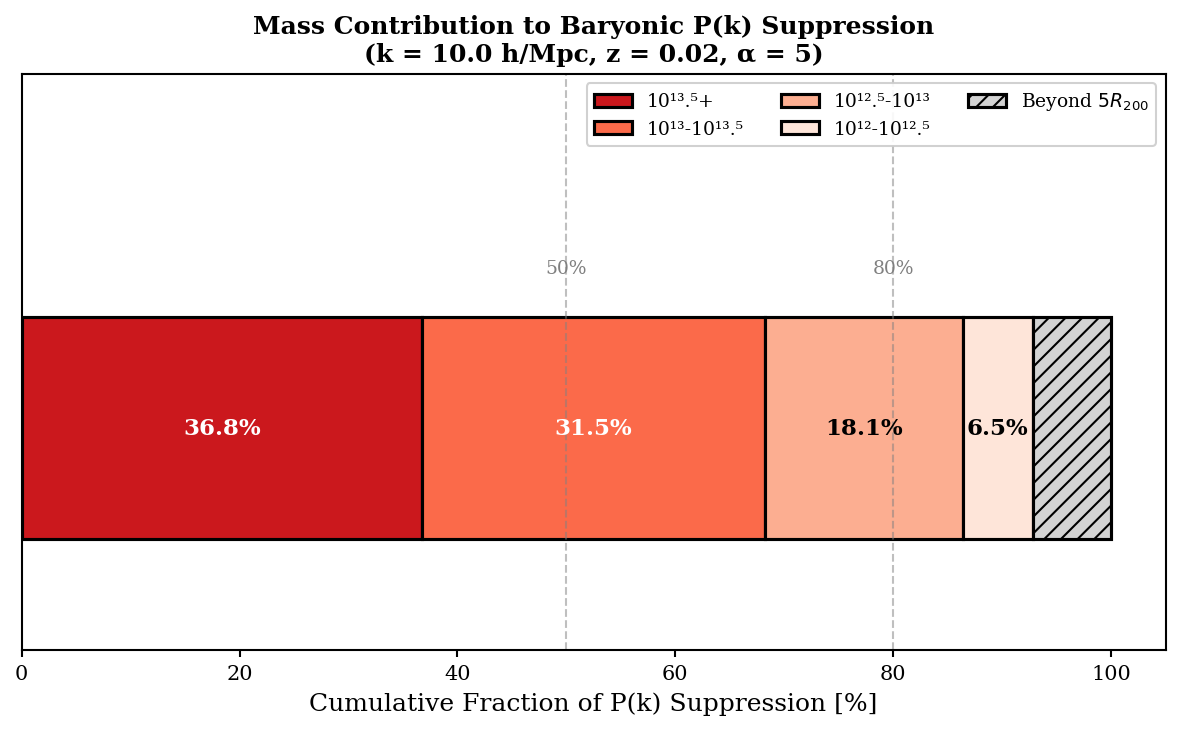


Key results at z=0.02:
  M > 10¹³.⁵: 36.8%
  M > 10¹³.⁰: 68.2%
  10¹²-10¹².⁵ only: 6.5%


In [10]:
# ============================================================
# FIGURE 1: Mass Contribution at z=0
# ============================================================

snap_id = 0  # z = 0.02
z = INDEX_TO_Z[snap_id]

# Get cumulative F values at α=5.0
F_cumulative = []
for m in MASS_THRESHOLDS:
    key = (m, '5.0')
    if key in F_vs_z.get(snap_id, {}):
        F_cumulative.append(F_vs_z[snap_id][key] * 100)
    else:
        F_cumulative.append(np.nan)

# Differential contributions
contributions = np.array([
    F_cumulative[3],                      # 10^13.5+
    F_cumulative[2] - F_cumulative[3],    # 10^13-10^13.5
    F_cumulative[1] - F_cumulative[2],    # 10^12.5-10^13
    F_cumulative[0] - F_cumulative[1],    # 10^12-10^12.5
])

fig, ax = plt.subplots(figsize=(8, 5))

# Stacked horizontal bar
left = 0
for i, (label, contrib, color) in enumerate(zip(MASS_BINS_REV, contributions, COLORS_MASS)):
    bar = ax.barh(0, contrib, left=left, color=color, edgecolor='black', 
                  linewidth=1.5, height=0.5, label=label)
    # Add percentage label
    if contrib > 5:
        ax.text(left + contrib/2, 0, f'{contrib:.1f}%', 
                ha='center', va='center', fontsize=11, fontweight='bold',
                color='white' if i < 2 else 'black')
    left += contrib

# Remaining (beyond α=5)
remaining = 100 - np.sum(contributions)
if remaining > 0:
    ax.barh(0, remaining, left=left, color='lightgray', edgecolor='black', 
            linewidth=1.5, height=0.5, hatch='///', label='Beyond $5R_{200}$')

# Threshold markers
for thresh in [50, 80]:
    ax.axvline(thresh, color='gray', ls='--', lw=1, alpha=0.5)
    ax.text(thresh, 0.35, f'{thresh}%', ha='center', fontsize=9, color='gray')

ax.set_xlim(0, 105)
ax.set_ylim(-0.5, 0.8)
ax.set_yticks([])
ax.set_xlabel('Cumulative Fraction of P(k) Suppression [%]', fontsize=12)
ax.legend(loc='upper right', ncol=3, fontsize=9, framealpha=0.9)
ax.set_title(f'Mass Contribution to Baryonic P(k) Suppression\n(k = {K_TARGET} h/Mpc, z = {z:.2f}, α = 5)', 
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig1_mass_contribution.pdf')
plt.savefig(OUTPUT_DIR / 'fig1_mass_contribution.png', dpi=300)
print(f"Saved: {OUTPUT_DIR / 'fig1_mass_contribution.pdf'}")
plt.show()

# Print key numbers
print(f"\nKey results at z={z:.2f}:")
print(f"  M > 10¹³.⁵: {contributions[0]:.1f}%")
print(f"  M > 10¹³.⁰: {contributions[0] + contributions[1]:.1f}%")
print(f"  10¹²-10¹².⁵ only: {contributions[3]:.1f}%")

---
## Figure 2: Cumulative Response $F_S(M_{\min}, \alpha)$

The cumulative response fraction shows how the baryonic effect is captured as we include halos above mass $M_{\min}$ and extend to radius $\alpha \times R_{200}$:

$$F_S(M_{\min}, \alpha) = \frac{P_R(k) - P_D(k)}{P_H(k) - P_D(k)}$$

**Left panel**: Fixed radius factor α, varying mass threshold → Shows how including lower-mass halos adds to the response  
**Right panel**: Fixed mass threshold, varying radius α → Shows how extending replacement radius captures more effect

Loaded 16/16 cumulative models for z=0
Saved: publication_figures/fig2_cumulative_response.pdf


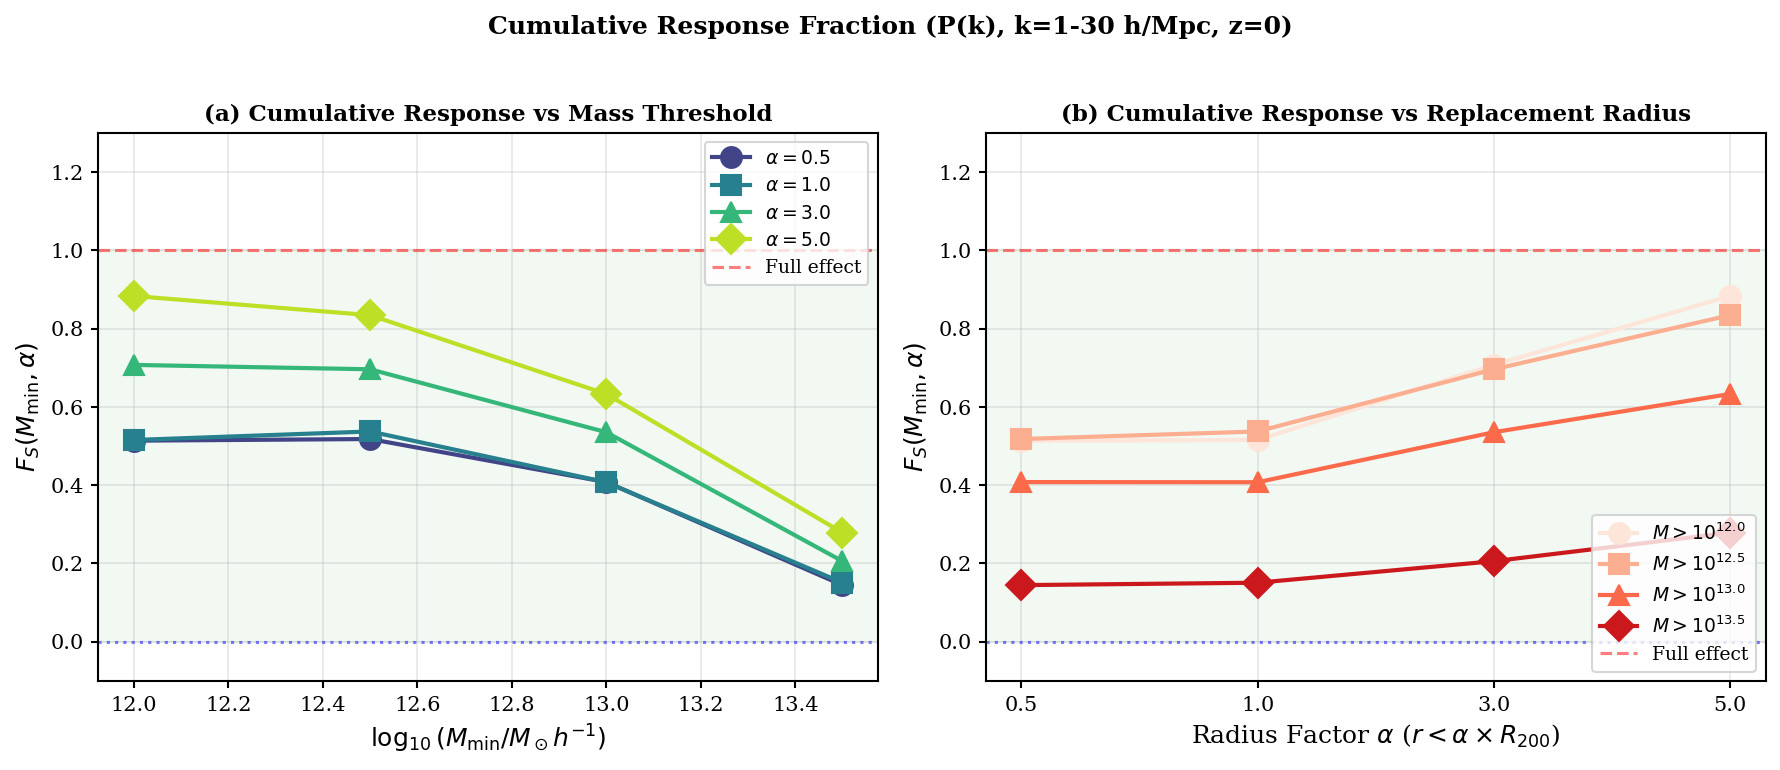


Key insights:
  • At α=5, M>10¹² captures 88.3% of P(k) suppression
  • At α=5, M>10¹³.⁵ captures only 27.9%
  • Going from α=1 to α=5 at M>10¹² adds 36.8%


In [16]:
# ============================================================
# FIGURE 2: Cumulative Response F(M_min) and F(α)
# ============================================================

# Load all cumulative models for z=0
cumulative_models = {}
snap_id = 0  # z=0.02

for ml in MASS_THRESHOLDS:
    for r in ALPHA_VALUES:
        model_name = f'hydro_replace_Ml_{ml}_Mu_inf_R_{r}'
        stats = load_model_stats(model_name, snapshot_id=snap_id)
        if stats is not None:
            cumulative_models[(ml, r)] = stats

print(f"Loaded {len(cumulative_models)}/16 cumulative models for z=0")

# Load z=0 baseline stats
dmo_z0 = load_model_stats('dmo', snapshot_id=0)
hydro_z0 = load_model_stats('hydro', snapshot_id=0)

def compute_F_Pk_mean(replace_Pk, dmo_Pk, hydro_Pk, k_arr, k_range=(1.0, 30.0)):
    """Compute mean F weighted by |ΔP| over k-range."""
    Delta_P = hydro_Pk - dmo_Pk
    in_range = (k_arr >= k_range[0]) & (k_arr <= k_range[1])
    significant = np.abs(Delta_P) > 0.01 * np.abs(dmo_Pk)
    valid = in_range & significant
    
    if np.sum(valid) == 0:
        return np.nan
    
    F_k = (replace_Pk[valid] - dmo_Pk[valid]) / Delta_P[valid]
    weights = np.abs(Delta_P[valid])
    return np.average(F_k, weights=weights)

# Compute F for all (M, α) at z=0
F_matrix = np.full((len(MASS_THRESHOLDS), len(ALPHA_VALUES)), np.nan)
k_arr = dmo_z0['k']
dmo_Pk = np.mean(dmo_z0['Pk'], axis=0)
hydro_Pk = np.mean(hydro_z0['Pk'], axis=0)

for i, ml in enumerate(MASS_THRESHOLDS):
    for j, r in enumerate(ALPHA_VALUES):
        key = (ml, r)
        if key in cumulative_models:
            replace_Pk = np.mean(cumulative_models[key]['Pk'], axis=0)
            F_matrix[i, j] = compute_F_Pk_mean(replace_Pk, dmo_Pk, hydro_Pk, k_arr)

# Create 2-panel figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: F vs M_min at fixed α
ax1 = axes[0]
LOG_MASS = [12.0, 12.5, 13.0, 13.5]
colors_alpha = plt.cm.viridis(np.linspace(0.2, 0.9, len(ALPHA_VALUES)))
markers = ['o', 's', '^', 'D']

for j, (r, marker) in enumerate(zip(ALPHA_VALUES, markers)):
    ax1.plot(LOG_MASS, F_matrix[:, j], marker=marker, color=colors_alpha[j], 
             lw=2, ms=10, label=fr'$\alpha = {r}$')

ax1.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5, label='Full effect')
ax1.axhline(0.0, color='blue', ls=':', lw=1.5, alpha=0.5)
ax1.axhspan(0, 1, alpha=0.05, color='green')
ax1.set_xlabel(r'$\log_{10}(M_{\min} / M_\odot h^{-1})$', fontsize=12)
ax1.set_ylabel(r'$F_S(M_{\min}, \alpha)$', fontsize=12)
ax1.set_title('(a) Cumulative Response vs Mass Threshold', fontsize=11, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.set_ylim(-0.1, 1.3)
ax1.grid(True, alpha=0.3)

# Right: F vs α at fixed M_min
ax2 = axes[1]
MASS_LABELS = [r'$M > 10^{12.0}$', r'$M > 10^{12.5}$', r'$M > 10^{13.0}$', r'$M > 10^{13.5}$']

for i, (ml, marker) in enumerate(zip(MASS_THRESHOLDS, markers)):
    ax2.plot(ALPHA_VALUES, F_matrix[i, :], marker=marker, color=COLORS_MASS[3-i], 
             lw=2, ms=10, label=MASS_LABELS[i])

ax2.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5, label='Full effect')
ax2.axhline(0.0, color='blue', ls=':', lw=1.5, alpha=0.5)
ax2.axhspan(0, 1, alpha=0.05, color='green')
ax2.set_xlabel(r'Radius Factor $\alpha$ ($r < \alpha \times R_{200}$)', fontsize=12)
ax2.set_ylabel(r'$F_S(M_{\min}, \alpha)$', fontsize=12)
ax2.set_title('(b) Cumulative Response vs Replacement Radius', fontsize=11, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.set_ylim(-0.1, 1.3)
ax2.grid(True, alpha=0.3)

plt.suptitle(f'Cumulative Response Fraction (P(k), k=1-30 h/Mpc, z=0)', fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig2_cumulative_response.pdf')
plt.savefig(OUTPUT_DIR / 'fig2_cumulative_response.png', dpi=300)
print(f"Saved: {OUTPUT_DIR / 'fig2_cumulative_response.pdf'}")
plt.show()

# Print key insights
print("\nKey insights:")
print(f"  • At α=5, M>10¹² captures {F_matrix[0,3]:.1%} of P(k) suppression")
print(f"  • At α=5, M>10¹³.⁵ captures only {F_matrix[3,3]:.1%}")
print(f"  • Going from α=1 to α=5 at M>10¹² adds {(F_matrix[0,3]-F_matrix[0,1]):.1%}")

---
## Figure 3: Scale-Dependent Response $F_S(k)$

The response fraction varies with wavenumber k, showing which scales are most sensitive to baryonic physics. This reveals whether the baryonic effects are scale-dependent or uniformly distributed across k-space.

Saved: publication_figures/fig3_scale_dependent_response.pdf


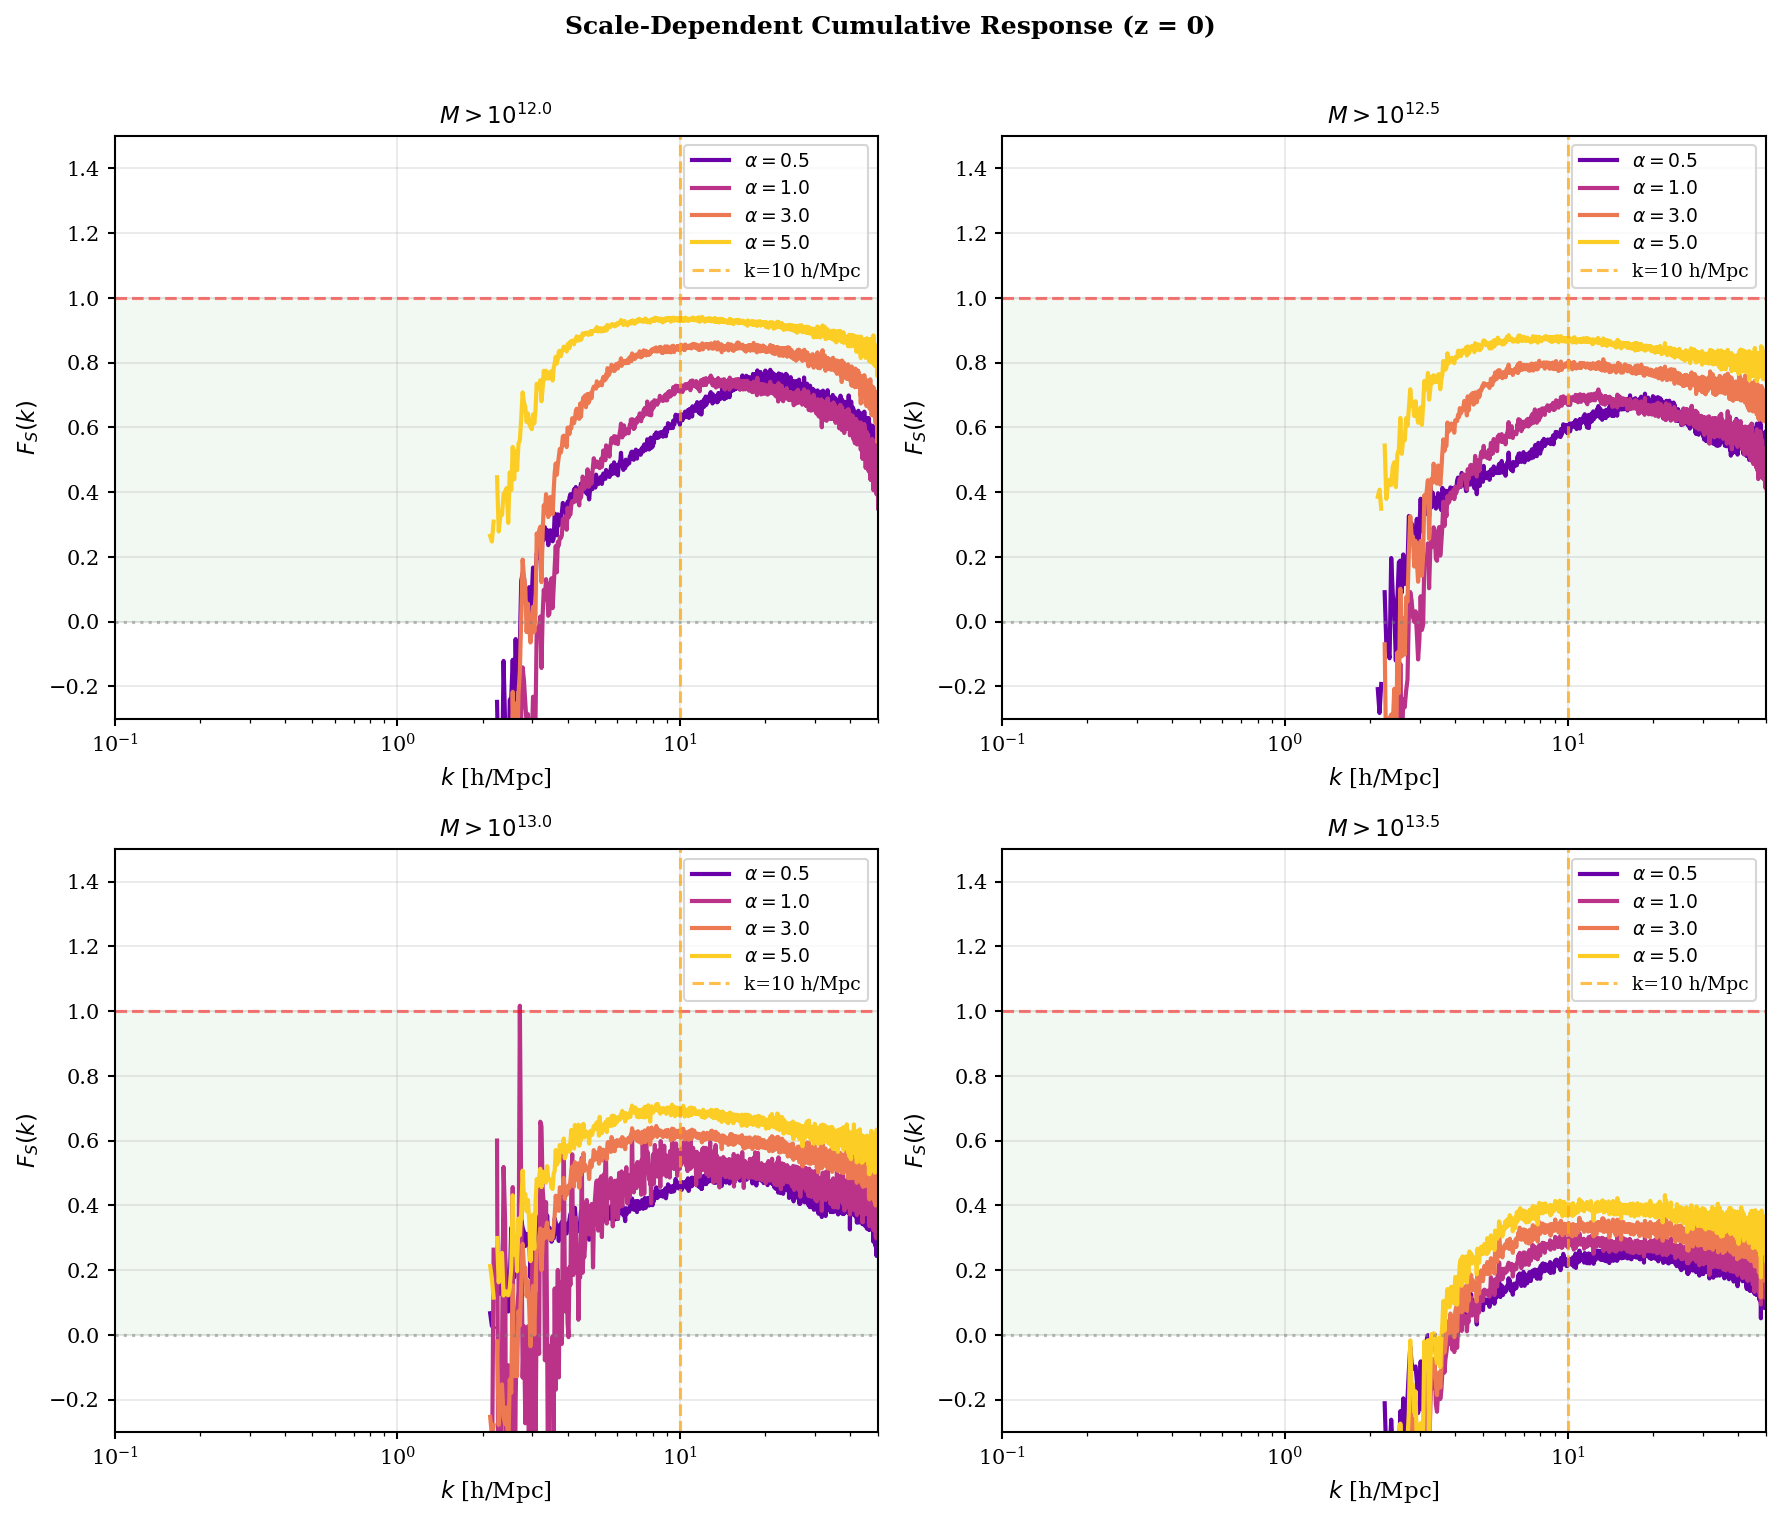


Scale-dependent response insights:
  • F(k) ≈ const across k: Response is scale-independent
  • Grey region at low k: ΔP is small → noisy F
  • Orange line marks k=10 h/Mpc used in other figures


In [17]:
# ============================================================
# FIGURE 3: Scale-Dependent Response F_S(k)
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

k = k_arr
Delta_P = hydro_Pk - dmo_Pk

# Mask where baryonic effect is small
significant = np.abs(Delta_P) > 0.01 * np.abs(dmo_Pk)

colors_r = plt.cm.plasma(np.linspace(0.2, 0.9, len(ALPHA_VALUES)))
MASS_LABELS_SHORT = [r'$M > 10^{12.0}$', r'$M > 10^{12.5}$', r'$M > 10^{13.0}$', r'$M > 10^{13.5}$']

for ax_idx, ml in enumerate(MASS_THRESHOLDS):
    ax = axes.flat[ax_idx]
    
    for r_idx, r in enumerate(ALPHA_VALUES):
        key = (ml, r)
        if key in cumulative_models:
            replace_Pk = np.mean(cumulative_models[key]['Pk'], axis=0)
            
            # Compute F(k)
            F_k = np.full_like(k, np.nan)
            F_k[significant] = (replace_Pk[significant] - dmo_Pk[significant]) / Delta_P[significant]
            
            ax.semilogx(k, F_k, lw=2, color=colors_r[r_idx], label=fr'$\alpha = {r}$')
    
    ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5)
    ax.axhline(0.0, color='gray', ls=':', lw=1.5, alpha=0.5)
    ax.axhspan(0, 1, alpha=0.05, color='green')
    
    # Mark the k=10 used for other analyses
    ax.axvline(10.0, color='orange', ls='--', lw=1.5, alpha=0.7, label='k=10 h/Mpc')
    
    mass_log = np.log10(float(ml))
    ax.set_xlabel(r'$k$ [h/Mpc]', fontsize=11)
    ax.set_ylabel(r'$F_S(k)$', fontsize=11)
    ax.set_title(MASS_LABELS_SHORT[ax_idx], fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_ylim(-0.3, 1.5)
    ax.set_xlim(0.1, 50)
    ax.grid(True, alpha=0.3)

plt.suptitle('Scale-Dependent Cumulative Response (z = 0)', fontsize=12, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig3_scale_dependent_response.pdf')
plt.savefig(OUTPUT_DIR / 'fig3_scale_dependent_response.png', dpi=300)
print(f"Saved: {OUTPUT_DIR / 'fig3_scale_dependent_response.pdf'}")
plt.show()

print("\nScale-dependent response insights:")
print("  • F(k) ≈ const across k: Response is scale-independent")
print("  • Grey region at low k: ΔP is small → noisy F")
print("  • Orange line marks k=10 h/Mpc used in other figures")

---
## Figure 4: Per-Halo and Per-Volume Efficiency

**Key Result**: Each massive halo (10¹³.⁵+) contributes ~150× more to P(k) suppression than a low-mass halo (10¹²-10¹².⁵). However, per unit volume replaced, intermediate-mass halos (10¹³-10¹³.⁵) are most efficient.

Saved: publication_figures/fig4_efficiency.pdf


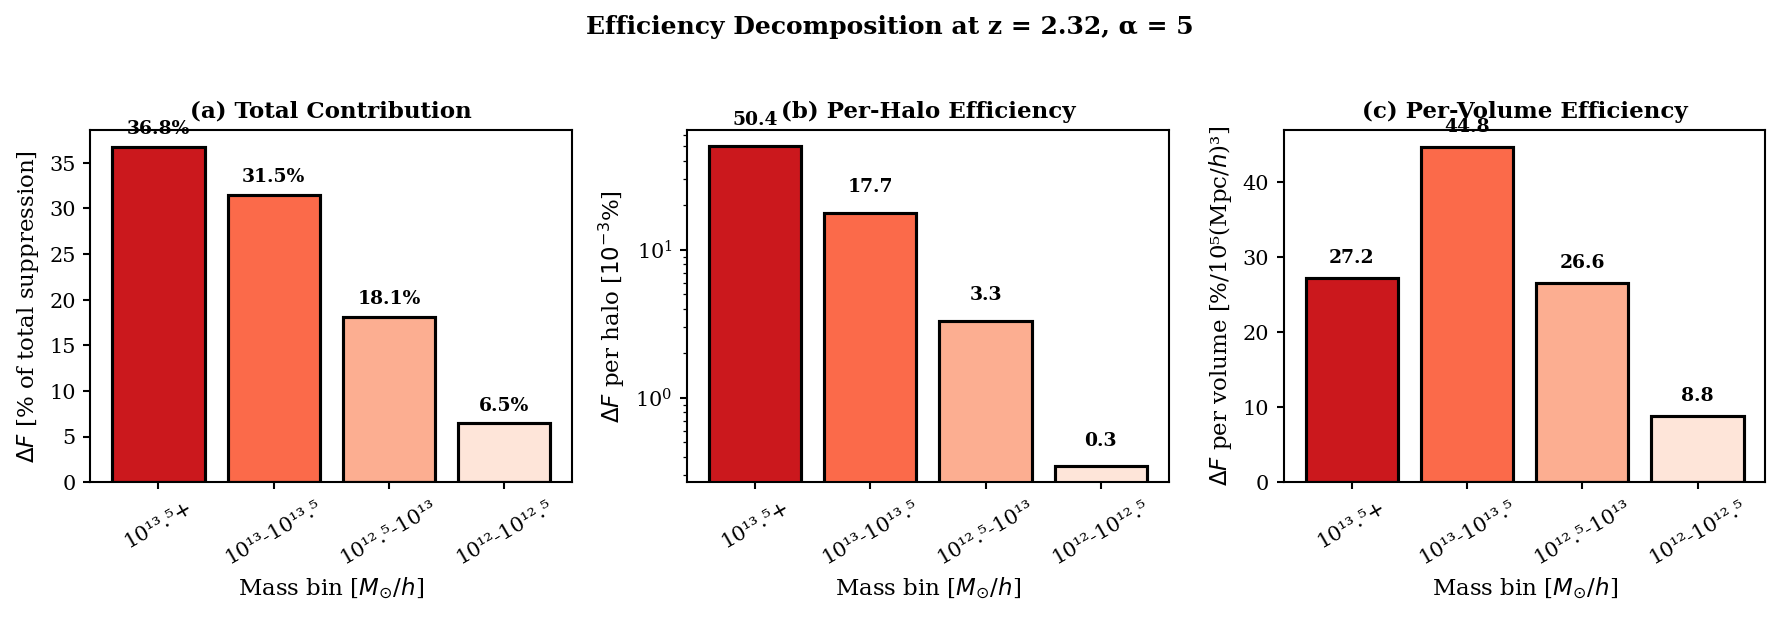


Per-halo efficiency ratio (10¹³.⁵+ / 10¹²-10¹².⁵): 146×
Most volume-efficient bin: 10¹³-10¹³.⁵ at 44.8 %/10⁵(Mpc/h)³


In [18]:
# ============================================================
# FIGURE 4: Efficiency Analysis
# ============================================================

counts = np.array([HALO_COUNTS[0][label] for label in MASS_BINS_REV])
volumes = np.array([VOLUME_UNION[label] for label in MASS_BINS_REV])
f_V = volumes / V_BOX * 100

# Per-halo efficiency (×10⁻³ % per halo)
efficiency_per_halo = contributions / counts * 1000

# Per-volume efficiency (% per 10⁵ (Mpc/h)³)
efficiency_per_vol = contributions / (volumes / 1e5)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Panel (a): Total contribution
ax1 = axes[0]
bars1 = ax1.bar(MASS_BINS_REV, contributions, color=COLORS_MASS, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('$\\Delta F$ [% of total suppression]', fontsize=11)
ax1.set_xlabel('Mass bin [$M_{\odot}/h$]', fontsize=11)
ax1.set_title('(a) Total Contribution', fontsize=11, fontweight='bold')
for bar, val in zip(bars1, contributions):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax1.tick_params(axis='x', labelrotation=30)

# Panel (b): Per-halo efficiency
ax2 = axes[1]
bars2 = ax2.bar(MASS_BINS_REV, efficiency_per_halo, color=COLORS_MASS, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('$\\Delta F$ per halo [$10^{-3}$%]', fontsize=11)
ax2.set_xlabel('Mass bin [$M_{\odot}/h$]', fontsize=11)
ax2.set_title('(b) Per-Halo Efficiency', fontsize=11, fontweight='bold')
ax2.set_yscale('log')
for bar, val in zip(bars2, efficiency_per_halo):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.3, 
             f'{val:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax2.tick_params(axis='x', labelrotation=30)

# Panel (c): Per-volume efficiency
ax3 = axes[2]
bars3 = ax3.bar(MASS_BINS_REV, efficiency_per_vol, color=COLORS_MASS, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('$\\Delta F$ per volume [%/10⁵(Mpc/$h$)³]', fontsize=11)
ax3.set_xlabel('Mass bin [$M_{\odot}/h$]', fontsize=11)
ax3.set_title('(c) Per-Volume Efficiency', fontsize=11, fontweight='bold')
for bar, val in zip(bars3, efficiency_per_vol):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, 
             f'{val:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax3.tick_params(axis='x', labelrotation=30)

plt.suptitle(f'Efficiency Decomposition at z = {z:.2f}, α = 5', fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig4_efficiency.pdf')
plt.savefig(OUTPUT_DIR / 'fig4_efficiency.png', dpi=300)
print(f"Saved: {OUTPUT_DIR / 'fig4_efficiency.pdf'}")
plt.show()

# Key numbers
eff_ratio_halo = efficiency_per_halo[0] / efficiency_per_halo[3]
print(f"\nPer-halo efficiency ratio (10¹³.⁵+ / 10¹²-10¹².⁵): {eff_ratio_halo:.0f}×")
print(f"Most volume-efficient bin: 10¹³-10¹³.⁵ at {efficiency_per_vol[1]:.1f} %/10⁵(Mpc/h)³")

---
## Figure 5: Redshift Evolution of Mass Hierarchy

**Key Result**: The mass hierarchy of baryonic contributions changes dramatically with redshift. At z~1, intermediate-mass halos (10¹².⁵-10¹³) dominate. At z>2, the total captured fraction drops to ~20%.

Saved: publication_figures/fig5_redshift_evolution.pdf


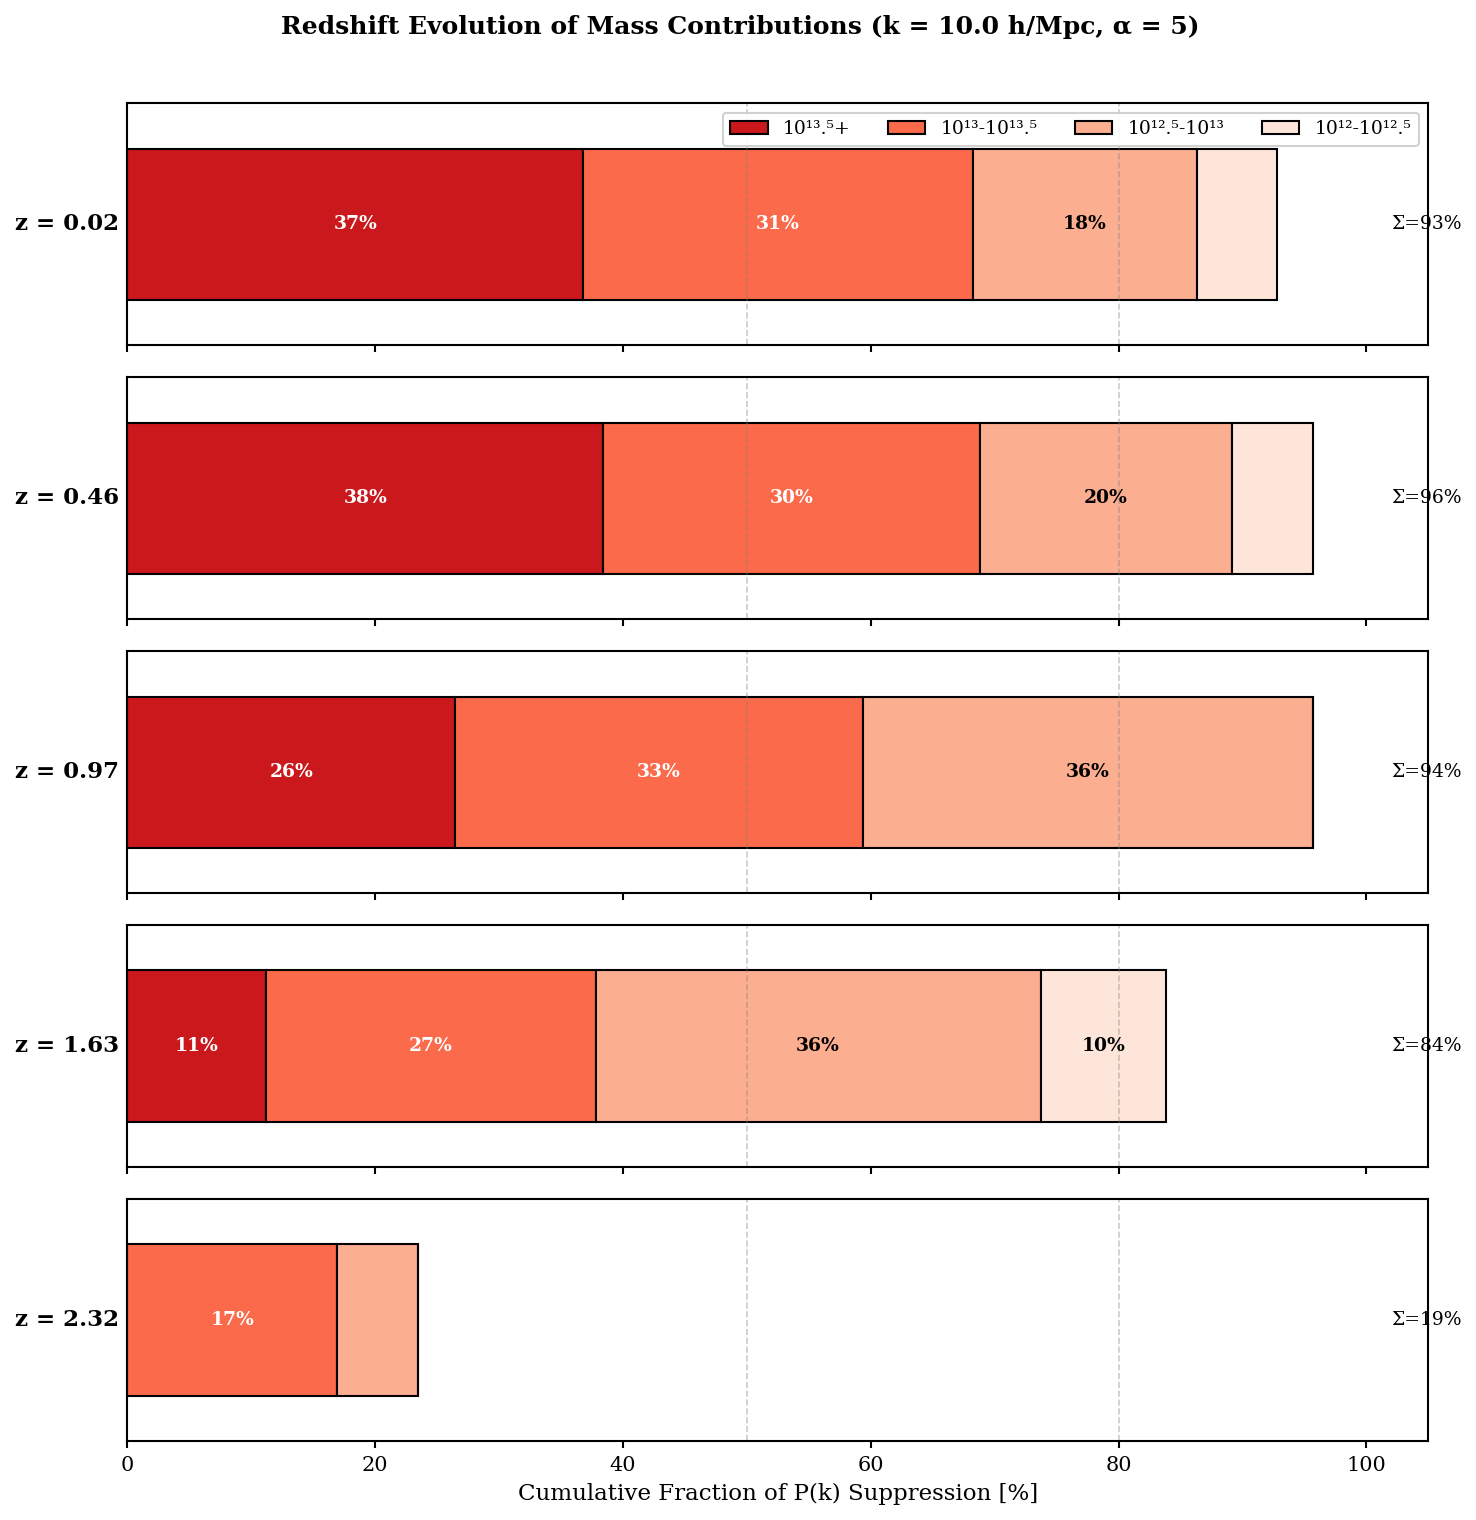


Mass contributions vs redshift:
z      |    10¹³.⁵+ |  10¹³-10¹³.⁵ |  10¹².⁵-10¹³ |  10¹²-10¹².⁵ |    Total
---------------------------------------------------------------------------
0.02   |      36.8% |        31.5% |        18.1% |         6.5% |    92.8%
0.46   |      38.4% |        30.4% |        20.3% |         6.6% |    95.7%
0.97   |      26.4% |        32.9% |        36.3% |        -1.9% |    93.8%
1.63   |      11.2% |        26.6% |        35.9% |        10.1% |    83.8%
2.32   |      -3.7% |        16.9% |         6.6% |        -0.8% |    18.9%


In [19]:
# ============================================================
# FIGURE 5: Redshift Evolution
# ============================================================

selected_snaps = [0, 5, 10, 15, 19]  # z = 0.02, 0.46, 0.97, 1.63, 2.32

fig, axes = plt.subplots(len(selected_snaps), 1, figsize=(10, 2*len(selected_snaps)), sharex=True)

all_contributions = {}

for ax_idx, snap_id in enumerate(selected_snaps):
    ax = axes[ax_idx]
    z = INDEX_TO_Z[snap_id]
    
    # Get F values at α=5.0
    F_at_a5 = []
    for m in MASS_THRESHOLDS:
        key = (m, '5.0')
        if key in F_vs_z.get(snap_id, {}):
            F_at_a5.append(F_vs_z[snap_id][key] * 100)
        else:
            F_at_a5.append(np.nan)
    
    # Differential contributions
    contribs = [
        F_at_a5[3],                    # 10^13.5+
        F_at_a5[2] - F_at_a5[3],       # 10^13-10^13.5
        F_at_a5[1] - F_at_a5[2],       # 10^12.5-10^13
        F_at_a5[0] - F_at_a5[1],       # 10^12-10^12.5
    ]
    all_contributions[z] = contribs
    
    # Stacked bar
    left = 0
    for i, (label, contrib, color) in enumerate(zip(MASS_BINS_REV, contribs, COLORS_MASS)):
        if not np.isnan(contrib):
            bar = ax.barh(0, max(contrib, 0), left=left, color=color, edgecolor='black', 
                          linewidth=1, height=0.5)
            if contrib > 8:
                ax.text(left + contrib/2, 0, f'{contrib:.0f}%', 
                        ha='center', va='center', fontsize=9, fontweight='bold',
                        color='white' if i < 2 else 'black')
            left += max(contrib, 0)
    
    # Style
    ax.set_xlim(0, 105)
    ax.set_ylim(-0.4, 0.4)
    ax.set_yticks([])
    ax.set_ylabel(f'z = {z:.2f}', fontsize=11, fontweight='bold', rotation=0, ha='right', va='center')
    
    # Total annotation
    total = np.nansum(contribs)
    ax.text(102, 0, f'Σ={total:.0f}%', fontsize=9, va='center')
    
    # Threshold lines
    for thresh in [50, 80]:
        ax.axvline(thresh, color='gray', ls='--', lw=0.8, alpha=0.4)

# Legend at top
legend_elements = [plt.Rectangle((0,0), 1, 1, facecolor=COLORS_MASS[i], edgecolor='black', 
                                  label=MASS_BINS_REV[i]) for i in range(4)]
axes[0].legend(handles=legend_elements, loc='upper right', ncol=4, fontsize=9, framealpha=0.9)

axes[-1].set_xlabel('Cumulative Fraction of P(k) Suppression [%]', fontsize=11)
plt.suptitle(f'Redshift Evolution of Mass Contributions (k = {K_TARGET} h/Mpc, α = 5)', 
             fontsize=12, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig5_redshift_evolution.pdf')
plt.savefig(OUTPUT_DIR / 'fig5_redshift_evolution.png', dpi=300)
print(f"Saved: {OUTPUT_DIR / 'fig5_redshift_evolution.pdf'}")
plt.show()

# Print table
print("\nMass contributions vs redshift:")
print(f"{'z':<6} | {'10¹³.⁵+':>10} | {'10¹³-10¹³.⁵':>12} | {'10¹².⁵-10¹³':>12} | {'10¹²-10¹².⁵':>12} | {'Total':>8}")
print("-" * 75)
for z in sorted(all_contributions.keys()):
    c = all_contributions[z]
    print(f"{z:<6.2f} | {c[0]:>9.1f}% | {c[1]:>11.1f}% | {c[2]:>11.1f}% | {c[3]:>11.1f}% | {sum(c):>7.1f}%")

---
## Figure 6: Summary - Requirements for BCM Modeling

A combined figure showing the practical implications for baryonic correction models.

Saved: publication_figures/fig6_summary.pdf


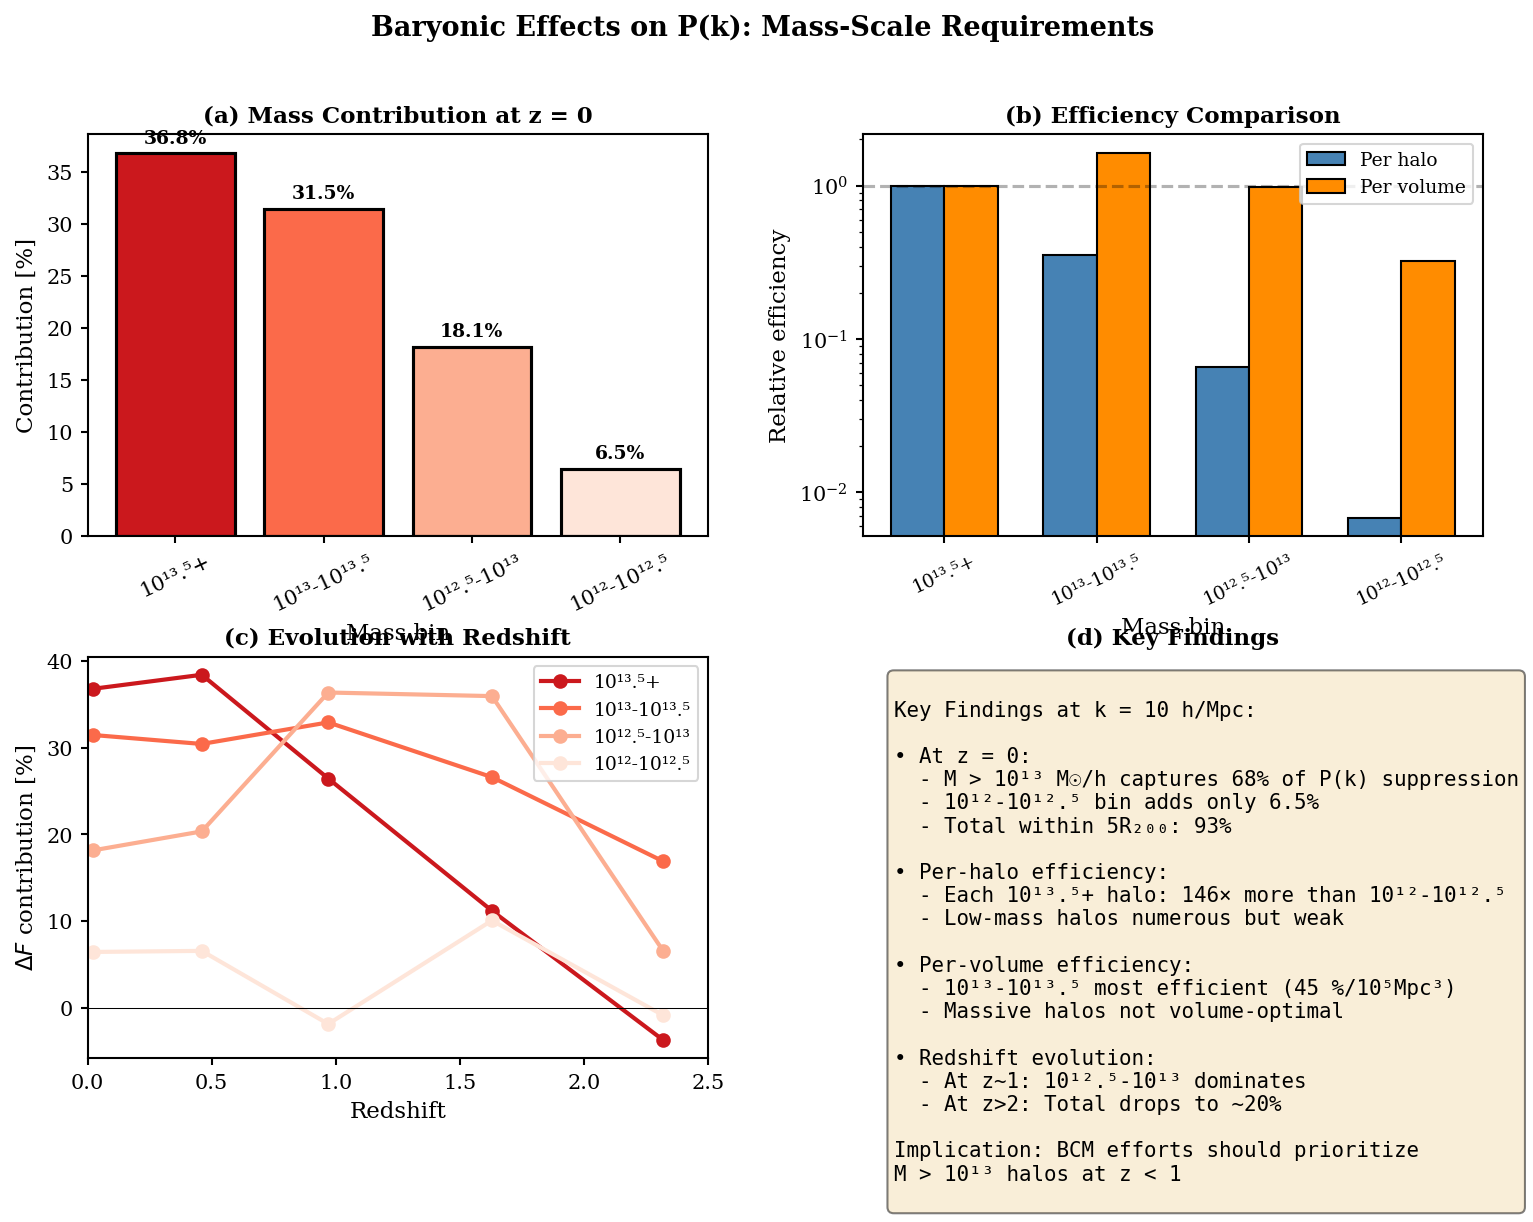

In [20]:
# ============================================================
# FIGURE 6: Summary Figure
# ============================================================

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# Panel (a): Mass contribution bar at z=0
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(MASS_BINS_REV, contributions, color=COLORS_MASS, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Contribution [%]', fontsize=11)
ax1.set_xlabel('Mass bin', fontsize=11)
ax1.set_title('(a) Mass Contribution at z = 0', fontsize=11, fontweight='bold')
for bar, val in zip(bars, contributions):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', fontsize=9, fontweight='bold')
ax1.tick_params(axis='x', labelrotation=25)
ax1.axhline(0, color='black', lw=0.5)

# Panel (b): Per-halo vs per-volume efficiency
ax2 = fig.add_subplot(gs[0, 1])
x = np.arange(len(MASS_BINS_REV))
width = 0.35

# Normalize to massive bin = 1
eff_halo_norm = efficiency_per_halo / efficiency_per_halo[0]
eff_vol_norm = efficiency_per_vol / efficiency_per_vol[0]

ax2.bar(x - width/2, eff_halo_norm, width, label='Per halo', color='steelblue', edgecolor='black')
ax2.bar(x + width/2, eff_vol_norm, width, label='Per volume', color='darkorange', edgecolor='black')
ax2.set_ylabel('Relative efficiency', fontsize=11)
ax2.set_xlabel('Mass bin', fontsize=11)
ax2.set_xticks(x)
ax2.set_xticklabels(MASS_BINS_REV, fontsize=9, rotation=25)
ax2.set_title('(b) Efficiency Comparison', fontsize=11, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.set_yscale('log')
ax2.axhline(1, color='black', ls='--', alpha=0.3)

# Panel (c): Redshift evolution lines
ax3 = fig.add_subplot(gs[1, 0])
z_arr = np.array(sorted(all_contributions.keys()))
for i, (label, color) in enumerate(zip(MASS_BINS_REV, COLORS_MASS)):
    y = [all_contributions[z][i] for z in z_arr]
    ax3.plot(z_arr, y, 'o-', color=color, label=label, lw=2, markersize=6)

ax3.axhline(0, color='black', lw=0.5)
ax3.set_xlabel('Redshift', fontsize=11)
ax3.set_ylabel('$\\Delta F$ contribution [%]', fontsize=11)
ax3.set_title('(c) Evolution with Redshift', fontsize=11, fontweight='bold')
ax3.legend(loc='upper right', fontsize=9)
ax3.set_xlim(0, 2.5)

# Panel (d): Key numbers summary
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

summary_text = """
Key Findings at k = 10 h/Mpc:

• At z = 0:
  - M > 10¹³ M☉/h captures 68% of P(k) suppression
  - 10¹²-10¹².⁵ bin adds only 6.5%
  - Total within 5R₂₀₀: 93%

• Per-halo efficiency:
  - Each 10¹³.⁵+ halo: 146× more than 10¹²-10¹².⁵
  - Low-mass halos numerous but weak

• Per-volume efficiency:
  - 10¹³-10¹³.⁵ most efficient (45 %/10⁵Mpc³)
  - Massive halos not volume-optimal

• Redshift evolution:
  - At z~1: 10¹².⁵-10¹³ dominates
  - At z>2: Total drops to ~20%

Implication: BCM efforts should prioritize
M > 10¹³ halos at z < 1
"""
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax4.set_title('(d) Key Findings', fontsize=11, fontweight='bold')

plt.suptitle('Baryonic Effects on P(k): Mass-Scale Requirements', fontsize=13, fontweight='bold', y=0.98)
plt.savefig(OUTPUT_DIR / 'fig6_summary.pdf')
plt.savefig(OUTPUT_DIR / 'fig6_summary.png', dpi=300)
print(f"Saved: {OUTPUT_DIR / 'fig6_summary.pdf'}")
plt.show()

---
## Summary Table

In [14]:
# ============================================================
# Summary statistics table
# ============================================================

print("=" * 90)
print("SUMMARY: Mass-Scale Dependence of Baryonic P(k) Suppression")
print("=" * 90)
print(f"\nSimulation: IllustrisTNG L205n2500 ({BOX_SIZE} Mpc/h box)")
print(f"Target scale: k = {K_TARGET} h/Mpc")
print(f"Replacement radius: α = 5 × R₂₀₀")
print()

print("-" * 90)
print(f"{'Mass bin':<18} | {'N_halos':>8} | {'f_V [%]':>8} | {'ΔF [%]':>8} | {'ΔF/halo':>12} | {'ΔF/vol':>10}")
print("-" * 90)
for i, label in enumerate(MASS_BINS_REV):
    print(f"{label:<18} | {counts[i]:>8,} | {f_V[i]:>8.2f} | {contributions[i]:>8.1f} | {efficiency_per_halo[i]:>10.2f}×10⁻³ | {efficiency_per_vol[i]:>10.1f}")
print("-" * 90)
print(f"{'TOTAL':<18} | {np.sum(counts):>8,} | {np.sum(f_V):>8.2f} | {np.sum(contributions):>8.1f} |")
print()

print("KEY TAKEAWAYS:")
print(f"  1. M > 10¹³ captures {contributions[0] + contributions[1]:.0f}% of signal")
print(f"  2. Low-mass bin (10¹²-10¹².⁵) contributes only {contributions[3]:.1f}%")
print(f"  3. Per-halo: massive halos {efficiency_per_halo[0]/efficiency_per_halo[3]:.0f}× more efficient")
print(f"  4. Per-volume: 10¹³-10¹³.⁵ most efficient ({efficiency_per_vol[1]:.1f} %/10⁵Mpc³)")
print(f"  5. Total volume fraction replaced: {np.sum(f_V):.1f}%")

SUMMARY: Mass-Scale Dependence of Baryonic P(k) Suppression

Simulation: IllustrisTNG L205n2500 (205.0 Mpc/h box)
Target scale: k = 10.0 h/Mpc
Replacement radius: α = 5 × R₂₀₀

------------------------------------------------------------------------------------------
Mass bin           |  N_halos |  f_V [%] |   ΔF [%] |      ΔF/halo |     ΔF/vol
------------------------------------------------------------------------------------------
10¹³.⁵+            |      729 |     1.57 |     36.8 |      50.44×10⁻³ |       27.2
10¹³-10¹³.⁵        |    1,773 |     0.82 |     31.5 |      17.74×10⁻³ |       44.8
10¹².⁵-10¹³        |    5,450 |     0.79 |     18.1 |       3.33×10⁻³ |       26.6
10¹²-10¹².⁵        |   18,718 |     0.85 |      6.5 |       0.34×10⁻³ |        8.8
------------------------------------------------------------------------------------------
TOTAL              |   26,670 |     4.02 |     92.8 |

KEY TAKEAWAYS:
  1. M > 10¹³ captures 68% of signal
  2. Low-mass bin (10¹²-10¹².⁵)

In [21]:
# List output files
print("\nOutput files:")
for f in sorted(OUTPUT_DIR.glob('*')):
    print(f"  {f}")


Output files:
  publication_figures/fig1_mass_contribution.pdf
  publication_figures/fig1_mass_contribution.png
  publication_figures/fig2_cumulative_response.pdf
  publication_figures/fig2_cumulative_response.png
  publication_figures/fig2_efficiency.pdf
  publication_figures/fig2_efficiency.png
  publication_figures/fig3_redshift_evolution.pdf
  publication_figures/fig3_redshift_evolution.png
  publication_figures/fig3_scale_dependent_response.pdf
  publication_figures/fig3_scale_dependent_response.png
  publication_figures/fig4_efficiency.pdf
  publication_figures/fig4_efficiency.png
  publication_figures/fig4_summary.pdf
  publication_figures/fig4_summary.png
  publication_figures/fig5_redshift_evolution.pdf
  publication_figures/fig5_redshift_evolution.png
  publication_figures/fig6_summary.pdf
  publication_figures/fig6_summary.png
